In [31]:
!nvidia-smi

Tue Sep 12 10:33:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8                2W /  N/A|    702MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Neccessary Libraries

In [32]:
import os
import random
from collections import namedtuple
import shutil
import time
import math
import pandas as pd
import numpy  as np
import cv2
from PIL import Image

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import dlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from skimage.feature import local_binary_pattern

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels


from sklearn.metrics import roc_curve, auc, classification_report

In [33]:
# Define seed to enable reproducibility of results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [34]:
folders = os.listdir(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\train")

In [35]:
# Check the size of the data
train_total = []
val_total = []
for folder in folders:
  train_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\train"
  train_total.append(len(os.listdir(train_dir + "\\" + folder)))
    
  val_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\\val"
  val_total.append(len(os.listdir(val_dir + "\\" + folder)))
print(f"Train Images--------- {sum(train_total)}\nValidation Images----------------- {sum(val_total)}")

test_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\test\Unknown"
print(f"Test Images----------- {len(os.listdir(test_dir))}")
print("")
print(f"Total number of Images: {sum(train_total) + sum(val_total) + (len(os.listdir(test_dir)))}")

Train Images--------- 20033
Validation Images----------------- 2856


Test Images----------- 5739

Total number of Images: 28628


## Schematics of Local Binary Patterns

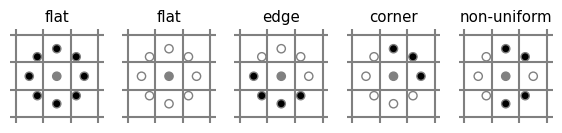

In [36]:
METHOD = 'uniform'
plt.rcParams['font.size'] = 9
def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)

def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)
fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

In [37]:
def lbp_transform(x):
    radius = 1
    n_points = 4 * radius
    METHOD = 'uniform'    
    imgUMat = np.float32(x)    
    gray = cv2.cvtColor(imgUMat, cv2.COLOR_RGB2GRAY)    
    lbp = local_binary_pattern(gray, n_points, radius, METHOD)
    lbp_image = Image.fromarray(lbp)
    lbp_image_rgb = lbp_image.convert('RGB')
    
    return lbp_image_rgb


In [38]:
batch_size = 32
transform_train = transforms.Compose([
    # transforms.Lambda(hogDetectFaces),
    # transforms.RandomHorizontalFlip(),
    transforms.Lambda(lbp_transform),
    transforms.ToTensor(),
    transforms.Normalize([0.0106, 0.0106, 0.0106],
                            [0.0050, 0.0050, 0.0050])
    ])

transform_test = transforms.Compose([
    # transforms.Lambda(hogDetectFaces),
    transforms.Lambda(lbp_transform),
    transforms.ToTensor(),
    transforms.Normalize([0.0106, 0.0106, 0.0106],
                            [0.0050, 0.0050, 0.0050])
   ])

# Load the datatsets from each folder

In [39]:
data_dir = r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer"

train = datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', 'train'),
    transform=transform_train)

In [40]:
val, test = [datasets.ImageFolder(
    os.path.join(data_dir, 'fer_train_val_test', folder),
    transform=transform_test) for folder in ['val', 'test']]

In [41]:
train_iter = data.DataLoader(train, batch_size, shuffle=True, drop_last=True)

valid_iter = data.DataLoader(val, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = data.DataLoader(test, batch_size, shuffle=False,
                                        drop_last=False)

### This is an additional code to check the mean and standard deviation of your dataset - you can then use it to replace the values in transforms.Normalize to improve your work

In [42]:
# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, label in train:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train)
# stds /= len(train)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

### Show image - display some of your images for observation.

In [43]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

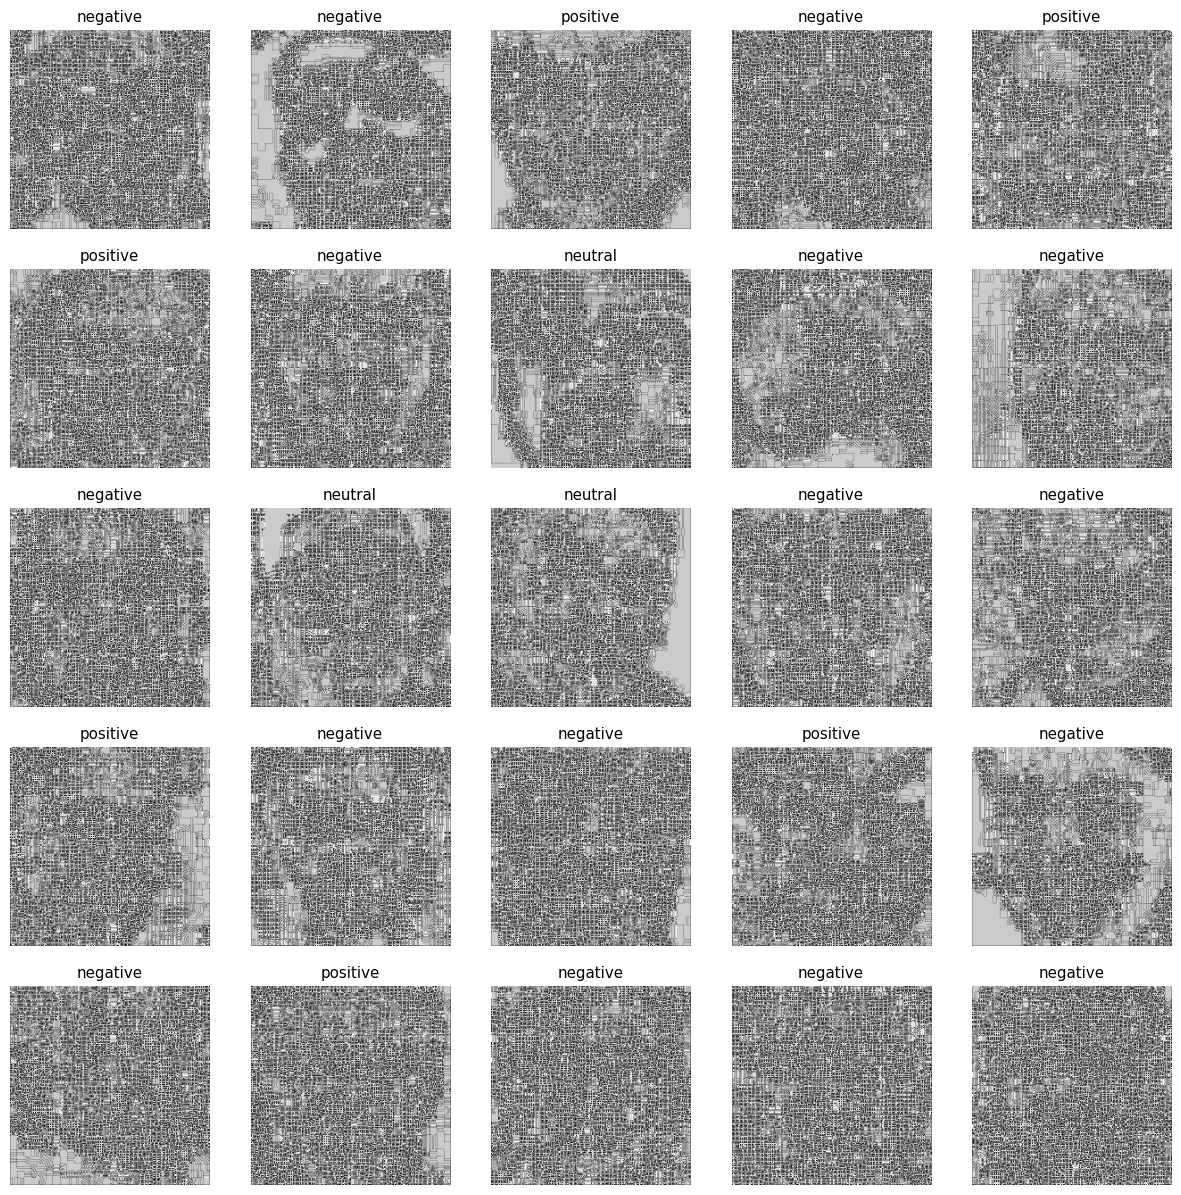

In [44]:
N_IMAGES = 25

images, labels = next(iter(train_iter))
image_label_pairs = list(zip(images, labels))
random.shuffle(image_label_pairs)
shuffled_images, shuffled_labels = zip(*image_label_pairs)
classes = train.classes

plot_images(shuffled_images[:N_IMAGES], shuffled_labels[:N_IMAGES], classes)

In [45]:
images[0].shape

torch.Size([3, 224, 224])

# Using SVM for classification

In [46]:
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.fc1 = nn.Linear(3 * 224 * 224, 3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [47]:
svm_model = SVM()
svm_model

SVM(
  (fc1): Linear(in_features=150528, out_features=3, bias=True)
)

In [48]:
def count_parameters(model):
    return __builtins__.sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(svm_model):,} trainable parameters')

The model has 451,587 trainable parameters


### Setting the hyperparameters and HINGELOSS class

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MultiMarginLoss()
svm_model = svm_model.to(device)
criterion = criterion.to(device)

In [50]:
FOUND_LR = 2e-4

# different optimizers
adam_opt = optim.Adam(svm_model.parameters(), lr=FOUND_LR)
sgd = optim.SGD(svm_model.parameters(), lr=FOUND_LR)
# sgd_nesterov_opt = optim.SGD(params, lr=FOUND_LR,momentum=0.9, nesterov=True)

In [51]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [52]:
def train_model(model, iterator, optimizer, criterion, device, scheduler=None ):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [53]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0

    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

In [54]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [55]:
def run_model(EPOCHS, model, opt, scheduler=None):
    counter = 0
    patience = 10
    best_valid_loss = float('inf')
    best_epoch = 0
    best_val_acc = float('inf')
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    for epoch in range(EPOCHS):        
        start_time = time.monotonic()
        if scheduler:
            train_loss, train_acc = train_model(model, train_iter, opt, criterion, device, scheduler)
            valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)
            if epoch >= 1:
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    best_val_acc = valid_acc
                    best_epoch = epoch
                    filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}fer_lbp_aug.pt"
                    torch.save(model.state_dict(), filename)
                    counter = 0
                else:
                    counter += 1  # increase patience counter on no improvement
                    if counter >= patience:
                        print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                        break
        else:
            train_loss, train_acc = train_model(model, train_iter, opt, criterion, device)
            valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)
            if epoch >= 1:
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    best_val_acc = valid_acc
                    best_epoch = epoch
                    filename = fr"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\{model.__class__.__name__}_{opt.__class__.__name__}fer_lbp_aug.pt"
                    torch.save(model.state_dict(), filename)
                    counter = 0
                else:
                    counter += 1  # increase patience counter on no improvement
                    if counter >= patience:
                        print(f"Validation loss hasn't improved in {patience} epochs. Stopping early.")
                        break

        

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}% |")
        print(f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}% |")
    print(f"best epcoh: {best_epoch+1}, best _validation accuracy: {best_val_acc}, best Validation loss: {best_valid_loss}")
    return train_accs, valid_accs, train_losses, valid_losses

In [57]:
train_accs, valid_accs, train_losses, valid_losses = run_model(20, svm_model, adam_opt)

c:\Users\kings\miniconda3\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
c:\Users\kings\miniconda3\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ..\aten\src\ATen\native\Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 01 | Epoch Time: 3m 45s
	Train Loss: 0.942 | Train Acc:  55.42% |
	Valid Loss: 1.074 | Valid Acc:  56.95% |
Epoch: 02 | Epoch Time: 3m 47s
	Train Loss: 0.230 | Train Acc:  85.58% |
	Valid Loss: 1.263 | Valid Acc:  59.59% |
Epoch: 03 | Epoch Time: 3m 46s
	Train Loss: 0.113 | Train Acc:  91.85% |
	Valid Loss: 1.394 | Valid Acc:  56.32% |
Epoch: 04 | Epoch Time: 3m 49s
	Train Loss: 0.090 | Train Acc:  93.39% |
	Valid Loss: 1.569 | Valid Acc:  57.41% |
Epoch: 05 | Epoch Time: 4m 8s
	Train Loss: 0.095 | Train Acc:  93.57% |
	Valid Loss: 1.736 | Valid Acc:  58.43% |
Epoch: 06 | Epoch Time: 4m 18s
	Train Loss: 0.094 | Train Acc:  94.00% |
	Valid Loss: 1.910 | Valid Acc:  55.65% |
Epoch: 07 | Epoch Time: 3m 58s
	Train Loss: 0.085 | Train Acc:  94.95% |
	Valid Loss: 2.027 | Valid Acc:  55.97% |
Epoch: 08 | Epoch Time: 4m 7s
	Train Loss: 0.065 | Train Acc:  95.78% |
	Valid Loss: 2.145 | Valid Acc:  58.15% |
Epoch: 09 | Epoch Time: 4m 32s
	Train Loss: 0.066 | Train Acc:  95.91% |
	Valid Lo

In [58]:
def plot_loss_acc():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(valid_losses, label='Validation Loss')
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Train vs Validation Loss", weight="bold")
    ax[0].legend()

    ax[1].plot(train_accs, label='Training Accuracy')
    ax[1].plot(valid_accs, label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[1].set_title("Train vs Validation Accuracy", weight="bold")
    ax[1].legend();
    plt.show()

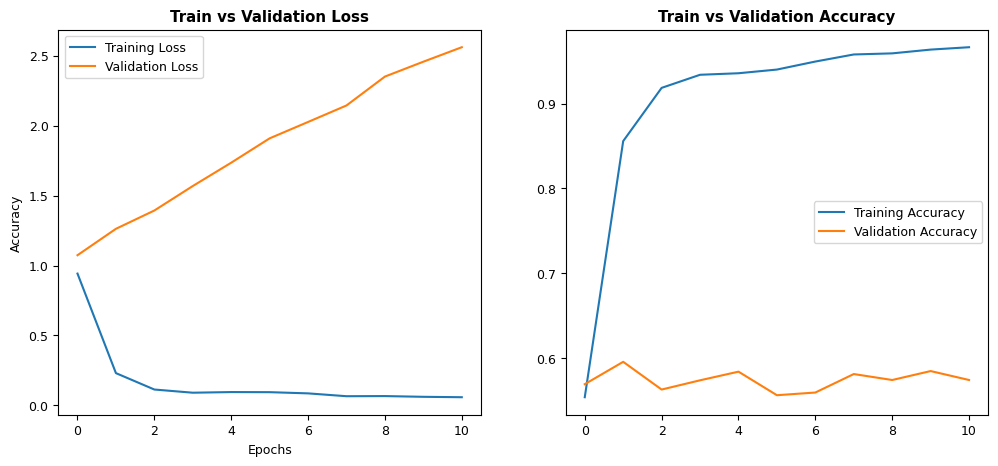

In [59]:
plot_loss_acc()

In [60]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [61]:
from scipy import interp
def plot_roc_curves(y_test, probs, class_labels):
    n_classes = len(class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of Proposed Method')
    plt.legend(loc="lower right")
    plt.show()


In [62]:
# Load the saved state dictionary
state_dict = torch.load(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\SVM_Adamfer_lbp_aug.pt")
svm_model = SVM()
# Replace the model's state dictionary with the saved state dictionary
svm_model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
svm_model = svm_model.to(device)
svm_model.eval()

SVM(
  (fc1): Linear(in_features=150528, out_features=3, bias=True)
)

In [63]:
images, labels, probs = get_predictions(svm_model, test_iter)

In [64]:
test = pd.read_csv(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\GroundTruth.csv")
y_test = np.array(test.drop(['id'], axis=1))
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)
class_names = unique_labels(true_class, pred_class)

In [65]:
test.columns

Index(['id', 'negative', 'neutral', 'positive'], dtype='object')

In [66]:
class_names

array([0, 1, 2], dtype=int64)

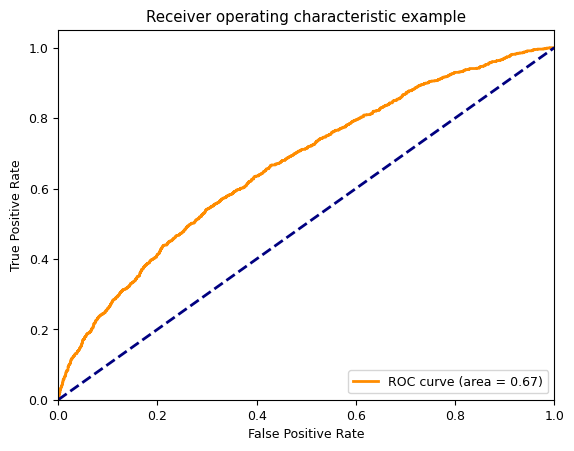

C:\Users\kings\AppData\Local\Temp\ipykernel_27160\3032910195.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


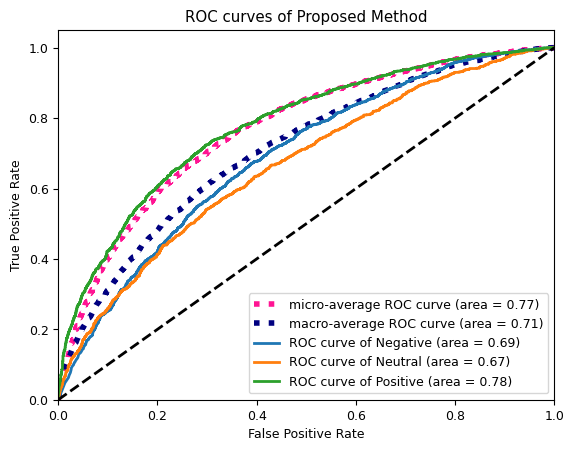

In [67]:
class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
class_names = [class_dict[label] for label in class_names]
plot_roc_curves(y_test, probs, class_names)

In [68]:
def plot_cm_class_report():
    cm=confusion_matrix(true_class, pred_class)
    class_names = unique_labels(true_class, pred_class)
    class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    class_names = [class_dict[label] for label in class_names]

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    C = cm
    divisor = np.zeros((3,3))
    divisor[0][:] = 2912
    divisor[1][:] = 1015
    divisor[2][:] = 1812
    cm_normalised=np.divide(cm, divisor)
    print(np.transpose(C.sum(axis=1)))
    cm_normalised = np.round(cm_normalised, 2)
    disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='');
    print(classification_report(true_class, pred_class))

[2912 1015 1812]
              precision    recall  f1-score   support

           0       0.61      0.77      0.68      2912
           1       0.39      0.23      0.29      1015
           2       0.62      0.51      0.56      1812

    accuracy                           0.59      5739
   macro avg       0.54      0.50      0.51      5739
weighted avg       0.58      0.59      0.58      5739



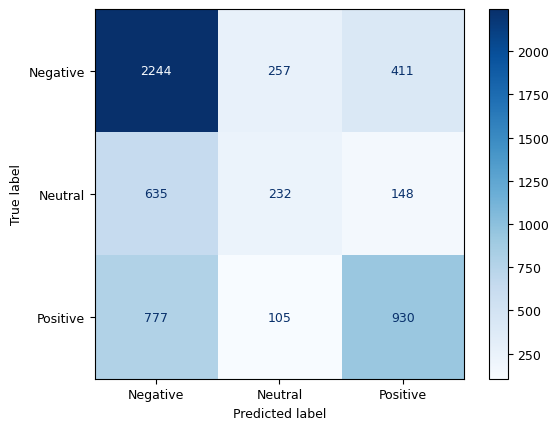

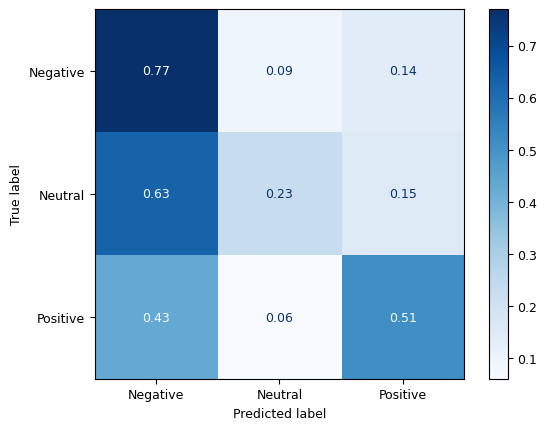

In [69]:
plot_cm_class_report()

### SGD as Optimizer

In [70]:
svm_model = SVM()

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MultiMarginLoss()
svm_model = svm_model.to(device)
criterion = criterion.to(device)

In [72]:
FOUND_LR = 2e-4

# different optimizers
# adam_opt = optim.Adam(svm_model.parameters(), lr=FOUND_LR)
sgd = optim.SGD(svm_model.parameters(), lr=FOUND_LR)
# sgd_nesterov_opt = optim.SGD(params, lr=FOUND_LR,momentum=0.9, nesterov=True)

In [73]:
train_accs, valid_accs, train_losses, valid_losses = run_model(20, svm_model, sgd)

c:\Users\kings\miniconda3\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
c:\Users\kings\miniconda3\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ..\aten\src\ATen\native\Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 01 | Epoch Time: 4m 50s
	Train Loss: 0.457 | Train Acc:  56.79% |
	Valid Loss: 0.419 | Valid Acc:  59.38% |
Epoch: 02 | Epoch Time: 3m 53s
	Train Loss: 0.225 | Train Acc:  77.43% |
	Valid Loss: 0.413 | Valid Acc:  60.57% |
Epoch: 03 | Epoch Time: 3m 44s
	Train Loss: 0.125 | Train Acc:  87.79% |
	Valid Loss: 0.423 | Valid Acc:  59.73% |
Epoch: 04 | Epoch Time: 3m 45s
	Train Loss: 0.071 | Train Acc:  93.58% |
	Valid Loss: 0.437 | Valid Acc:  57.83% |
Epoch: 05 | Epoch Time: 3m 47s
	Train Loss: 0.040 | Train Acc:  96.88% |
	Valid Loss: 0.436 | Valid Acc:  58.32% |
Epoch: 06 | Epoch Time: 3m 59s
	Train Loss: 0.022 | Train Acc:  98.55% |
	Valid Loss: 0.438 | Valid Acc:  58.53% |
Epoch: 07 | Epoch Time: 3m 43s
	Train Loss: 0.012 | Train Acc:  99.22% |
	Valid Loss: 0.441 | Valid Acc:  58.04% |
Epoch: 08 | Epoch Time: 3m 38s
	Train Loss: 0.006 | Train Acc:  99.69% |
	Valid Loss: 0.445 | Valid Acc:  57.69% |
Epoch: 09 | Epoch Time: 3m 32s
	Train Loss: 0.003 | Train Acc:  99.87% |
	Valid 

In [74]:
def plot_loss_acc():
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(valid_losses, label='Validation Loss')
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Train vs Validation Loss", weight="bold")
    ax[0].legend()

    ax[1].plot(train_accs, label='Training Accuracy')
    ax[1].plot(valid_accs, label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[1].set_title("Train vs Validation Accuracy", weight="bold")
    ax[1].legend();
    plt.show()

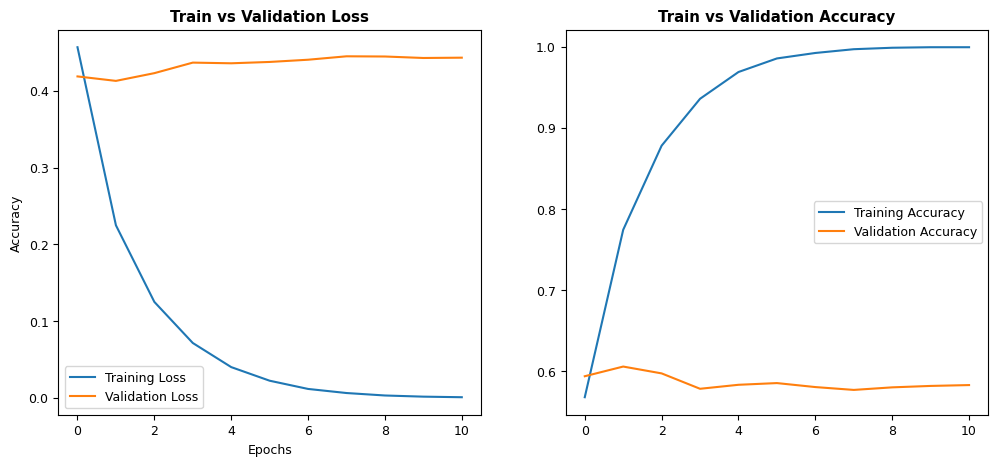

In [75]:
plot_loss_acc()

In [76]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [77]:
from scipy import interp
def plot_roc_curves(y_test, probs, class_labels):
    n_classes = len(class_labels)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of Proposed Method')
    plt.legend(loc="lower right")
    plt.show()


In [78]:
# Load the saved state dictionary
state_dict = torch.load(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\models\SVM_SGDfer_lbp_aug.pt")
svm_model = SVM()
# Replace the model's state dictionary with the saved state dictionary
svm_model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
svm_model = svm_model.to(device)
svm_model.eval()

SVM(
  (fc1): Linear(in_features=150528, out_features=3, bias=True)
)

In [79]:
images, labels, probs = get_predictions(svm_model, test_iter)

In [80]:
test = pd.read_csv(r"C:\Users\kings\OneDrive - MMU\MSC DATA SCIENCE\MSC Project\datasets\fer\fer_train_val_test\GroundTruth.csv")
y_test = np.array(test.drop(['id'], axis=1))
pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)
class_names = unique_labels(true_class, pred_class)

In [81]:
test.columns

Index(['id', 'negative', 'neutral', 'positive'], dtype='object')

In [82]:
class_names

array([0, 1, 2], dtype=int64)

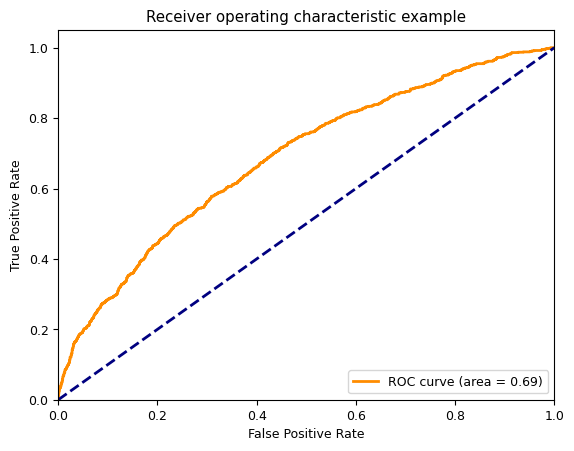

C:\Users\kings\AppData\Local\Temp\ipykernel_27160\3032910195.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


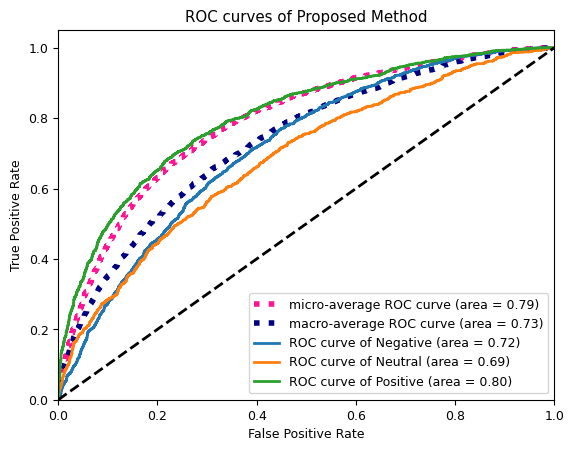

In [83]:
class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
class_names = [class_dict[label] for label in class_names]
plot_roc_curves(y_test, probs, class_names)

In [84]:
def plot_cm_class_report():
    cm=confusion_matrix(true_class, pred_class)
    class_names = unique_labels(true_class, pred_class)
    class_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    class_names = [class_dict[label] for label in class_names]

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    C = cm
    divisor = np.zeros((3,3))
    divisor[0][:] = 2912
    divisor[1][:] = 1015
    divisor[2][:] = 1812
    cm_normalised=np.divide(cm, divisor)
    print(np.transpose(C.sum(axis=1)))
    cm_normalised = np.round(cm_normalised, 2)
    disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='');
    print(classification_report(true_class, pred_class))

[2912 1015 1812]
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      2912
           1       0.41      0.21      0.28      1015
           2       0.65      0.56      0.60      1812

    accuracy                           0.62      5739
   macro avg       0.56      0.52      0.53      5739
weighted avg       0.60      0.62      0.59      5739



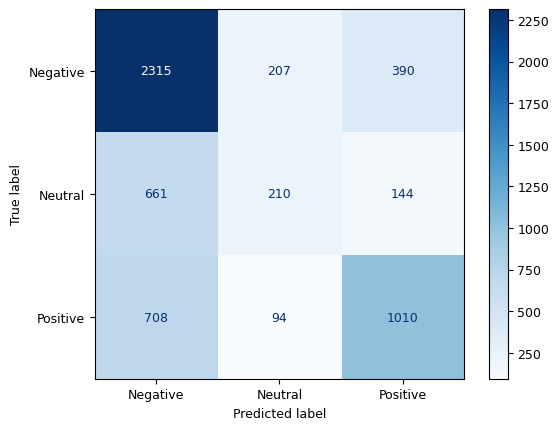

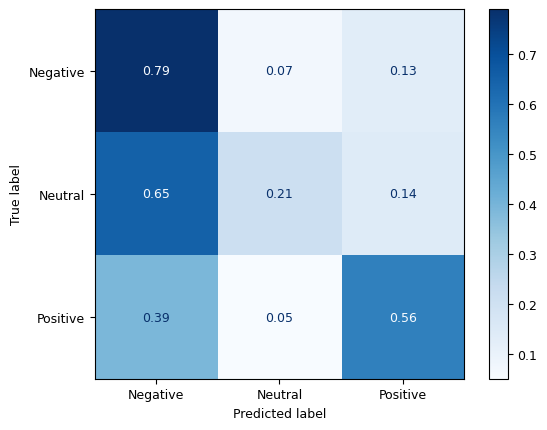

In [85]:
plot_cm_class_report()

Using SGD is a better optimizer with SVM than adam